In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
from pathlib import Path
import pandas as pd
import etta
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from astropy.time import Time
import arviz as az

In [3]:
#Wobble results for TOI 4517_01

RESULTS_DIR = '/srv/scratch/astro/z5345592/results/tess_toi/4517_01'
RESULTS_PATH = Path(RESULTS_DIR) / '4517_01_wobble_rvs.txt'
RESULTS_TABLE = pd.read_csv(RESULTS_PATH, sep=' ', header=3)

In [4]:
TOI_INFO_TABLE = etta.download_toi('4517.01')

Fetching data from https://exofop.ipac.caltech.edu/tess/download_toi.php?output=pipe&toi=4517.01


In [5]:
#getting the useful information out of the tables.

dates = np.array(RESULTS_TABLE['dates'])
rvs_norm = np.array(RESULTS_TABLE['RV'] - np.median(RESULTS_TABLE['RV']))
rvs_err = np.array(RESULTS_TABLE['RV_err'])

x_ref = 0.5 * (dates.min() + dates.max()) # this is needed for some pymc3 stuff later
t = np.linspace(dates.min() - 5, dates.max() + 5, 50000)

toi_period = TOI_INFO_TABLE['Period (days)']
toi_period_err = TOI_INFO_TABLE['Period (days) err']
toi_epoch = TOI_INFO_TABLE['Epoch (BJD)']
toi_epoch_err = TOI_INFO_TABLE['Epoch (BJD) err']

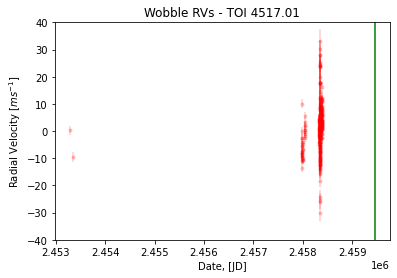

In [6]:
plt.errorbar(dates, rvs_norm, yerr=rvs_err, fmt='r.', alpha = 0.2)
plt.ylabel('Radial Velocity [$ms^{-1}$]')
plt.xlabel('Date, [JD]')
plt.title('Wobble RVs - TOI 4517.01')
plt.ylim(-40,40)
plt.axvline(x=float(toi_epoch), c='g', label = 'TESS Transit')

In [8]:
from scipy.optimize import curve_fit

def straight_line(x, m, c):
    return (m * x) + c

popt, pcov = curve_fit(straight_line, dates, rvs_norm, sigma=rvs_err, p0=[0.1, -1000])

fit_sigma = np.sqrt(np.diag(pcov))

gradient = popt[0]
intercept = popt[1]

gradient_sigma = fit_sigma[0]
intercept_sigma = fit_sigma[1]

gradient_max = gradient + gradient_sigma
gradient_min = gradient - gradient_sigma

intercept_max = intercept + intercept_sigma
intercept_min = intercept - intercept_sigma

<ErrorbarContainer object of 3 artists>

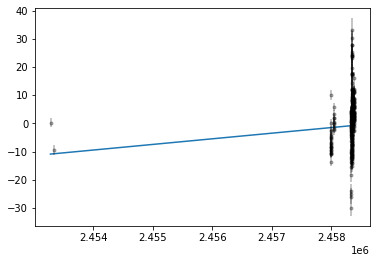

In [9]:
time_grid = np.linspace(np.min(dates)-10, np.max(dates)+10, 50000)

plt.figure()
plt.plot(time_grid, straight_line(time_grid, popt[0], popt[1]))
plt.errorbar(dates, rvs_norm, yerr=rvs_err, fmt='k.', alpha = 0.3)

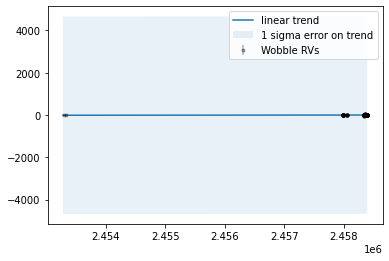

In [11]:
plt.figure()
plt.plot(time_grid, straight_line(time_grid, gradient, intercept), label = 'linear trend')

plt.errorbar(dates, rvs_norm, yerr=rvs_err, fmt='k.', alpha = 0.3, label = 'Wobble RVs')
plt.fill_between(time_grid, straight_line(time_grid, gradient_max, intercept_max), straight_line(time_grid, gradient_min, intercept_min), alpha=0.1, ec=None, label = '1 sigma error on trend')
plt.legend()